In [2]:
!pip install keras

In [5]:
# Importing libraries

import re
import pandas as pd
import numpy as np
import nltk
# nltk.download('all')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import precision_score, recall_score
#from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer

from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras import Sequential

#### Dataset Loading

In [6]:
# reading data

data = pd.read_csv(r'googleplaystore_user_reviews.csv')

data.head()

,App,Translated_Review,Sentiment
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive
2,10 Best Foods for You,NaN,NaN
3,10 Best Foods for You,Works great especially going grocery store,Positive
4,10 Best Foods for You,Best idea us,Positive


In [7]:
# drop unnecessary columns and rename cols

data.drop(['App'], axis=1, inplace=True)

data.columns = ['review', 'sentiment']

data.head()

,review,sentiment
0,I like eat delicious food. That's I'm cooking ...,Positive
1,This help eating healthy exercise regular basis,Positive
2,NaN,NaN
3,Works great especially going grocery store,Positive
4,Best idea us,Positive


#### EDA

In [8]:
# check data shape

data.shape

(64295, 2)

In [9]:
# check missing values

data.isna().sum()

,0
review,26868
sentiment,26863


In [10]:
# dropping null values

data.dropna(inplace=True) # droping the rows which has null values as we r not sure what values will come.

<Axes: xlabel='sentiment'>

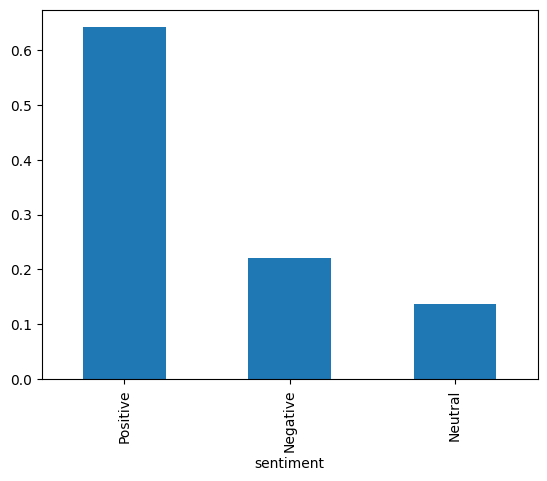

In [11]:
# check target balance

data['sentiment'].value_counts(normalize = True).plot.bar()

#### Text Preprocessing pipeline

In [12]:
# text preprocessing
# here since we have embeddings for class string only and not for numbers etc, so removing anything apart from string.
# lly, removing stopwords, converting text into lower case,etc. Getting lemmatization and after that joining the words again.
# And apending in a corpus.

def preprocess_pipeline(text_data):
    # create a list text

    lemmatizer = WordNetLemmatizer()

    if str(type(text_data)) != "<class 'str'>":
        text = list(text_data)

        # preprocessing loop

        corpus = []

        for i in range(len(text)):

            r = re.sub('[^a-zA-Z]', ' ', text[i])

            r = r.lower()

            r = r.split()

            r = [word for word in r if word not in stopwords.words('english')]

            r = [lemmatizer.lemmatize(word) for word in r]

            r = ' '.join(r)

            corpus.append(r)

        return corpus

    else:

        r = re.sub('[^a-zA-Z]', ' ', text_data)

        r = r.lower()

        r = r.split()

        r = [word for word in r if word not in stopwords.words('english')]

        r = [lemmatizer.lemmatize(word) for word in r]

        r = ' '.join(r)

        return r

In [15]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
#assign corpus to data['text']
preprocessed_text = preprocess_pipeline(data['review'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [16]:
data['review'] = preprocessed_text

data.head()

,review,sentiment
0,like eat delicious food cooking food case best...,Positive
1,help eating healthy exercise regular basis,Positive
3,work great especially going grocery store,Positive
4,best idea u,Positive
5,best way,Positive


In [17]:
data.to_csv('sentiments_cleaned_data.csv', index=False)

In [18]:
data.head()

,review,sentiment
0,like eat delicious food cooking food case best...,Positive
1,help eating healthy exercise regular basis,Positive
3,work great especially going grocery store,Positive
4,best idea u,Positive
5,best way,Positive


#### Train-Test split

In [19]:
# Create Feature and Label sets

X = data['review']

y = data['sentiment']


# train test split (66% train - 33% test)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


print('Training Data :', X_train.shape)

print('Testing Data : ', X_test.shape)

Training Data : (26198,)
Testing Data :  (11229,)


In [20]:
from sklearn.preprocessing import LabelEncoder # positive,-ve,neutral
le = LabelEncoder()

le.fit(y)

y_train = le.transform(y_train)
y_test = le.transform(y_test)

#### Feature Extraction

In [21]:
# Installing gensim

# %pip install gensim

In [22]:
# Pre trained Word2Vec model

from gensim.models import Word2Vec,KeyedVectors

##### Pre-trained embeddings

In [24]:
import gensim.downloader as api
path = api.load("word2vec-google-news-300", return_path=True)
print(path)

[==================================================] 100.0% 1662.8/1662.8MB downloaded
/root/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz


In [25]:
#embed_model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin',binary=True)
embed_model= KeyedVectors.load_word2vec_format(path,binary=True)

In [26]:
# Generating embeddings

def vectorize(sentence):
    words = sentence.split()
    words_vecs = [embed_model[word] for word in words if word in embed_model]
    if len(words_vecs) == 0:
        return np.zeros(300)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

X_train_embed_trained = np.array([vectorize(sentence) for sentence in X_train])
X_test_embed_trained = np.array([vectorize(sentence) for sentence in X_test])

#### Model Training and evaluation

#### Using pre-trained embeddings

In [27]:
model = Sequential()
model.add(Dense(128,input_shape = (300,), activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(64, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(64, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(32, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(16, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(3,activation='softmax'))
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │          38,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 16)                  │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 54,819 (214.14 KB)

 Trainable params: 54,211 (211.76 KB)

 Non-trainable params: 608 (2.38 KB)

In [28]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [29]:
model.fit(X_train_embed_trained, np.array(y_train, dtype='float'), epochs=20, validation_split=0.2)

Epoch 1/20
655/655 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.5592 - loss: 0.9797 - val_accuracy: 0.7727 - val_loss: 0.5582
Epoch 2/20
655/655 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.7463 - loss: 0.5974 - val_accuracy: 0.8111 - val_loss: 0.4755
Epoch 3/20
655/655 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7791 - loss: 0.5432 - val_accuracy: 0.8134 - val_loss: 0.4629
Epoch 4/20
655/655 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7915 - loss: 0.5160 - val_accuracy: 0.8059 - val_loss: 0.4809
Epoch 5/20
655/655 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8064 - loss: 0.4786 - val_accuracy: 0.8074 - val_loss: 0.4669
Epoch 6/20
655/655 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7997 - loss: 0.4879 - val_accuracy: 0.8174 - val_loss: 0.4481
Epoch 7/20
655/655 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8127 - loss: 0.4569 - val_accuracy: 0.8292 - val_loss: 0.4458
Epoch 8/20
655/655 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.8209 - loss: 0.4472 - val_accuracy: 

In [30]:
probabilities = model.predict(X_test_embed_trained)

probabilities

351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


array([[1.6697520e-01, 5.2108341e-03, 8.2781392e-01],
       [1.4493258e-02, 7.4266293e-04, 9.8476410e-01],
       [4.0957096e-01, 3.0268505e-02, 5.6016064e-01],
       ...,
       [6.9262648e-01, 6.1239887e-02, 2.4613358e-01],
       [4.4647958e-02, 1.9275532e-03, 9.5342445e-01],
       [8.0559427e-01, 2.2936001e-02, 1.7146972e-01]], dtype=float32)

In [31]:
predictions = np.argmax(probabilities, axis=1)

predictions

array([2, 2, 2, ..., 0, 2, 0])

In [32]:
# confusion matrix
from sklearn import metrics

df = pd.DataFrame(metrics.confusion_matrix(y_test,predictions),index=['Negative','Neutral','Positive'], columns=['Negative','Neutral','Positive'])

df
'''
for class -ve.
TP = 1722
TN = 1103+6586
FP = 178+442
FN = 111+648

Next is Positive Sentiment--
TP -- 6586
TN -- 1722+1103
FP -- 648+267
FN -- 442+172

'''

,Negative,Neutral,Positive
Negative,1722,111,648
Neutral,178,1103,267
Positive,442,172,6586


In [33]:
precision = precision_score(y_test, predictions, average='weighted')
recall = recall_score(y_test, predictions, average='weighted')

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

Precision: 0.84
Recall: 0.84


#### Using Embeddings in Keras library

In [ ]:
'''
while working with keras library embedding layer , donot remove stopwords.
becaUSE HERE even the stopwords have special meaing defined in the embedding layer.
'''

In [34]:
# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [35]:
vocab_size = len(tokenizer.word_index) + 1 # +1 is for extra space, in case if the vocabulary is not present in the dataset
vocab_size

15385

In [36]:
# Pad the sequences to a fixed length
max_length = 300
X_train = pad_sequences(X_train, maxlen=max_length, padding='post')
X_test = pad_sequences(X_test, maxlen=max_length, padding='post')

In [37]:
# Define the ANN model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=max_length)) #
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(64, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(32, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(16, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(4, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(3, activation='softmax'))

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [38]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.3)

Epoch 1/10
574/574 ━━━━━━━━━━━━━━━━━━━━ 70s 106ms/step - accuracy: 0.4322 - loss: 1.0736 - val_accuracy: 0.6377 - val_loss: 0.9356
Epoch 2/10
574/574 ━━━━━━━━━━━━━━━━━━━━ 45s 78ms/step - accuracy: 0.7331 - loss: 0.6301 - val_accuracy: 0.6642 - val_loss: 0.7047
Epoch 3/10
574/574 ━━━━━━━━━━━━━━━━━━━━ 94s 100ms/step - accuracy: 0.8679 - loss: 0.3766 - val_accuracy: 0.7639 - val_loss: 0.5294
Epoch 4/10
574/574 ━━━━━━━━━━━━━━━━━━━━ 79s 94ms/step - accuracy: 0.9134 - loss: 0.2744 - val_accuracy: 0.7779 - val_loss: 0.5853
Epoch 5/10
574/574 ━━━━━━━━━━━━━━━━━━━━ 81s 92ms/step - accuracy: 0.9352 - loss: 0.2198 - val_accuracy: 0.8127 - val_loss: 0.5748
Epoch 6/10
574/574 ━━━━━━━━━━━━━━━━━━━━ 78s 85ms/step - accuracy: 0.9444 - loss: 0.1801 - val_accuracy: 0.6996 - val_loss: 0.7377
Epoch 7/10
574/574 ━━━━━━━━━━━━━━━━━━━━ 90s 100ms/step - accuracy: 0.9488 - loss: 0.1755 - val_accuracy: 0.8158 - val_loss: 0.5492
Epoch 8/10
574/574 ━━━━━━━━━━━━━━━━━━━━ 48s 83ms/step - accuracy: 0.9566 - loss: 0.1521

In [39]:
probabilities = model.predict(X_test)

probabilities

351/351 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step


array([[1.1017609e-02, 3.2766908e-03, 9.8570573e-01],
       [1.5440249e-03, 8.1530149e-04, 9.9764073e-01],
       [9.5627807e-02, 5.4130503e-03, 8.9895910e-01],
       ...,
       [9.9754274e-01, 2.7793919e-04, 2.1793996e-03],
       [8.5265341e-04, 4.4840222e-04, 9.9869895e-01],
       [9.9474818e-01, 6.4225239e-04, 4.6095201e-03]], dtype=float32)

In [40]:
predictions = np.argmax(probabilities, axis=1)

predictions

array([2, 2, 2, ..., 0, 2, 0])

In [41]:
# confusion matrix
from sklearn import metrics

df = pd.DataFrame(metrics.confusion_matrix(y_test,predictions),index=['Negative','Neutral','Positive'], columns=['Negative','Neutral','Positive'])

df

,Negative,Neutral,Positive
Negative,1999,0,482
Neutral,548,35,965
Positive,407,1,6792


In [42]:
precision = precision_score(y_test, predictions, average='weighted')
recall = recall_score(y_test, predictions, average='weighted')

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

Precision: 0.81
Recall: 0.79


In [43]:
model.evaluate(X_test, y_test, verbose=1)

351/351 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7800 - loss: 0.8330


[0.8133105635643005, 0.7860005497932434]

In [43]:
'''
Now ANN is not good for sequential data. Because we r unable to track sequential data with ANN.
So we go for RNN
'''